<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-12-06 17:00:00+09:00,413,0,327,2020-12-06 17:00:00+09:00
2020-12-07 17:00:00+09:00,413,0,299,2020-12-07 17:00:00+09:00
2020-12-08 17:00:00+09:00,414,0,352,2020-12-08 17:00:00+09:00
2020-12-09 17:00:00+09:00,479,0,572,2020-12-09 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-12-06 17:00:00+09:00,413,0,327,2020-12-06 17:00:00+09:00,458.857143,3212.0,0.0,0.0,439.428571,3076.0
2020-12-07 17:00:00+09:00,413,0,299,2020-12-07 17:00:00+09:00,445.000000,3115.0,0.0,0.0,437.714286,3064.0
2020-12-08 17:00:00+09:00,414,0,352,2020-12-08 17:00:00+09:00,439.000000,3073.0,0.0,0.0,434.857143,3044.0
2020-12-09 17:00:00+09:00,479,0,572,2020-12-09 17:00:00+09:00,447.000000,3129.0,0.0,0.0,445.142857,3116.0
2020-12-10 17:00:00+09:00,0,0,602,2020-12-10 17:00:00+09:00,380.857143,2666.0,0.0,0.0,455.000000,3185.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-11-26 17:00:00+09:00,484,0,481,2020-11-26 17:00:00+09:00,590.714286,4135.0,0.0,0.0,404.857143,2834.0,'20w48,Thu
2020-11-27 17:00:00+09:00,517,0,570,2020-11-27 17:00:00+09:00,577.714286,4044.0,0.0,0.0,411.714286,2882.0,'20w48,Fri
2020-11-28 17:00:00+09:00,590,0,561,2020-11-28 17:00:00+09:00,557.714286,3904.0,0.0,0.0,414.857143,2904.0,'20w48,Sat
2020-11-29 17:00:00+09:00,496,0,418,2020-11-29 17:00:00+09:00,539.714286,3778.0,0.0,0.0,418.714286,2931.0,'20w48,Sun
2020-11-30 17:00:00+09:00,510,0,311,2020-11-30 17:00:00+09:00,517.857143,3625.0,0.0,0.0,418.285714,2928.0,'20w49,Mon
2020-12-01 17:00:00+09:00,456,0,372,2020-12-01 17:00:00+09:00,503.571429,3525.0,0.0,0.0,444.857143,3114.0,'20w49,Tue
2020-12-02 17:00:00+09:00,423,0,500,2020-12-02 17:00:00+09:00,496.571429,3476.0,0.0,0.0,459.000000,3213.0,'20w49,Wed
2020-12-03 17:00:00+09:00,463,0,533,2020-12-03 17:00:00+09:00,493.571429,3455.0,0.0,0.0,466.428571,3265.0,'20w49,Thu
2020-12-04 17:00:00+09:00,406,0,449,2020-12-04 17:00:00+09:00,477.714286,3344.0,0.0,0.0,449.142857,3144.0,'20w49,Fri
2020-12-05 17:00:00+09:00,541,0,584,2020-12-05 17:00:00+09:00,470.714286,3295.0,0.0,0.0,452.428571,3167.0,'20w49,Sat


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-11-15 17:00:00+09:00,305.571429,2139
2020-11-22 17:00:00+09:00,421.142857,2948
2020-11-29 17:00:00+09:00,418.714286,2931
2020-12-06 17:00:00+09:00,439.428571,3076
2020-12-10 17:00:00+09:00,456.250000,1825


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-11-26 17:00:00+09:00,484,0,481,2020-11-26 17:00:00+09:00,590.714286,4135.0,0.0,0.0,404.857143,2834.0,'20w48,Thu,NaN,NaN
2020-11-27 17:00:00+09:00,517,0,570,2020-11-27 17:00:00+09:00,577.714286,4044.0,0.0,0.0,411.714286,2882.0,'20w48,Fri,NaN,NaN
2020-11-28 17:00:00+09:00,590,0,561,2020-11-28 17:00:00+09:00,557.714286,3904.0,0.0,0.0,414.857143,2904.0,'20w48,Sat,NaN,NaN
2020-11-29 17:00:00+09:00,496,0,418,2020-11-29 17:00:00+09:00,539.714286,3778.0,0.0,0.0,418.714286,2931.0,'20w48,Sun,418.714286,2931.0
2020-11-30 17:00:00+09:00,510,0,311,2020-11-30 17:00:00+09:00,517.857143,3625.0,0.0,0.0,418.285714,2928.0,'20w49,Mon,NaN,NaN
2020-12-01 17:00:00+09:00,456,0,372,2020-12-01 17:00:00+09:00,503.571429,3525.0,0.0,0.0,444.857143,3114.0,'20w49,Tue,NaN,NaN
2020-12-02 17:00:00+09:00,423,0,500,2020-12-02 17:00:00+09:00,496.571429,3476.0,0.0,0.0,459.000000,3213.0,'20w49,Wed,NaN,NaN
2020-12-03 17:00:00+09:00,463,0,533,2020-12-03 17:00:00+09:00,493.571429,3455.0,0.0,0.0,466.428571,3265.0,'20w49,Thu,NaN,NaN
2020-12-04 17:00:00+09:00,406,0,449,2020-12-04 17:00:00+09:00,477.714286,3344.0,0.0,0.0,449.142857,3144.0,'20w49,Fri,NaN,NaN
2020-12-05 17:00:00+09:00,541,0,584,2020-12-05 17:00:00+09:00,470.714286,3295.0,0.0,0.0,452.428571,3167.0,'20w49,Sat,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

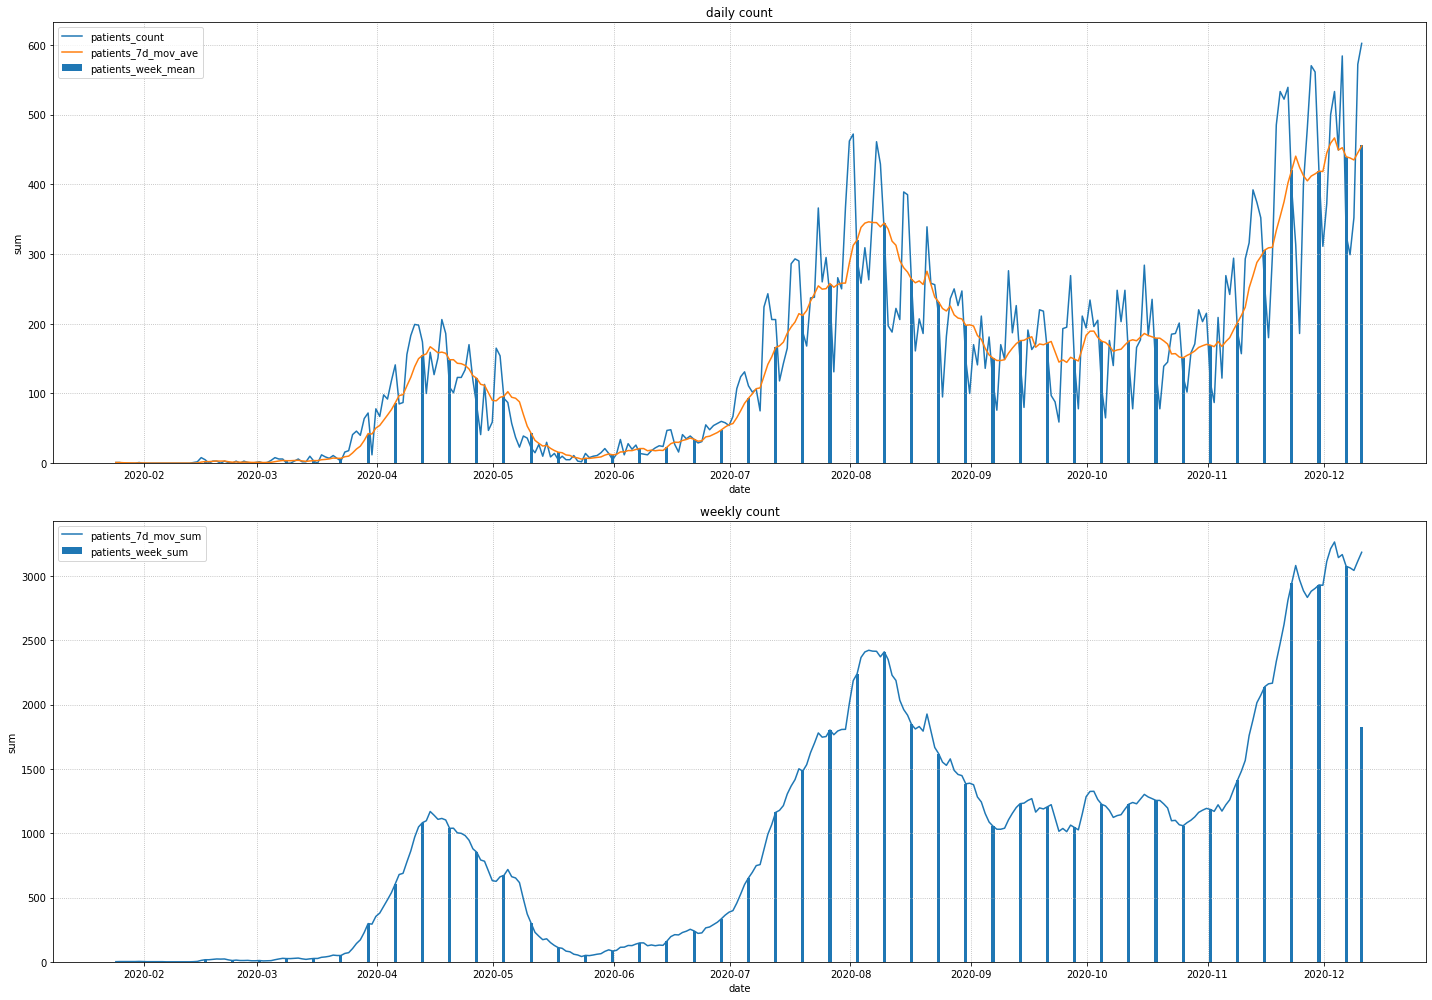

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
307,1.606378e+09,2020,11,26,0,0,0,0,1,0,0,307,0,233,484,590.714286,4135.0,0,0.0,0.0,481,404.857143,2834.0
308,1.606464e+09,2020,11,27,1,0,0,0,0,0,0,308,0,234,517,577.714286,4044.0,0,0.0,0.0,570,411.714286,2882.0
309,1.606550e+09,2020,11,28,0,0,1,0,0,0,0,309,0,235,590,557.714286,3904.0,0,0.0,0.0,561,414.857143,2904.0
310,1.606637e+09,2020,11,29,0,0,0,1,0,0,0,310,0,236,496,539.714286,3778.0,0,0.0,0.0,418,418.714286,2931.0
311,1.606723e+09,2020,11,30,0,1,0,0,0,0,0,311,0,237,510,517.857143,3625.0,0,0.0,0.0,311,418.285714,2928.0
312,1.606810e+09,2020,12,1,0,0,0,0,0,1,0,312,0,238,456,503.571429,3525.0,0,0.0,0.0,372,444.857143,3114.0
313,1.606896e+09,2020,12,2,0,0,0,0,0,0,1,313,0,239,423,496.571429,3476.0,0,0.0,0.0,500,459.000000,3213.0
314,1.606982e+09,2020,12,3,0,0,0,0,1,0,0,314,0,240,463,493.571429,3455.0,0,0.0,0.0,533,466.428571,3265.0
315,1.607069e+09,2020,12,4,1,0,0,0,0,0,0,315,0,241,406,477.714286,3344.0,0,0.0,0.0,449,449.142857,3144.0
316,1.607155e+09,2020,12,5,0,0,1,0,0,0,0,316,0,242,541,470.714286,3295.0,0,0.0,0.0,584,452.428571,3167.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            322 non-null    float64
 1   year                 322 non-null    int64  
 2   month                322 non-null    int64  
 3   day                  322 non-null    int64  
 4   Fri                  322 non-null    uint8  
 5   Mon                  322 non-null    uint8  
 6   Sat                  322 non-null    uint8  
 7   Sun                  322 non-null    uint8  
 8   Thu                  322 non-null    uint8  
 9   Tue                  322 non-null    uint8  
 10  Wed                  322 non-null    uint8  
 11  passed               322 non-null    int64  
 12  emergency            322 non-null    int64  
 13  em_passed            322 non-null    int64  
 14  contacts_count       322 non-null    int64  
 15  contacts_7d_mov_ave  322 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.220000e+02,322.0,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,1.593720e+09,2020.0,6.549689,15.683230,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,160.500000,0.152174,95.118012,747.869565,744.917850,5214.413043,1144.468944,1144.468944,8011.282609,141.394410,136.958429,958.658385
std,8.043634e+06,0.0,3.071173,8.953269,0.350472,0.350472,0.350472,0.350472,0.350472,0.350472,0.350472,93.097619,0.359748,81.656249,476.536232,463.974762,3247.842417,842.459003,692.132557,4844.927902,139.064777,124.549809,871.904276
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586786e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.250000,0.000000,6.250000,440.500000,452.714286,3169.000000,357.000000,865.285714,6057.000000,14.250000,17.857143,125.000000
50%,1.593720e+09,2020.0,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160.500000,0.000000,86.500000,591.500000,611.500000,4280.500000,1169.000000,1177.642857,8243.500000,116.000000,145.785714,1020.500000
75%,1.600654e+09,2020.0,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.750000,0.000000,166.750000,869.500000,904.678571,6332.750000,1719.500000,1637.821429,11464.750000,211.000000,194.285714,1360.000000
max,1.607587e+09,2020.0,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,321.000000,1.000000,247.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,602.000000,466.428571,3265.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,NaN,0.995408,-0.018698,-1.317597e-02,-7.204234e-18,-8.783978e-03,-4.391989e-03,1.317597e-02,4.391989e-03,8.783978e-03,1.000000e+00,-2.848614e-01,0.985270,-0.113770,-0.075922,-0.075916,-0.019099,3.020300e-02,3.020300e-02,0.734534,0.793960,0.794009
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.954079e-01,NaN,1.000000,-0.114193,-1.529824e-02,-8.269317e-04,-9.509715e-03,-3.721193e-03,1.364437e-02,4.961590e-03,1.075011e-02,9.954079e-01,-2.817789e-01,0.980032,-0.110696,-0.073936,-0.073929,-0.019277,3.221180e-02,3.221180e-02,0.733754,0.792632,0.792686
day,-1.869844e-02,NaN,-0.114193,1.000000,2.340164e-02,8.509686e-03,7.516889e-03,-6.382265e-03,-5.389468e-03,-6.382265e-03,-2.127422e-02,-1.869844e-02,5.046239e-04,-0.016951,-0.001569,0.009108,0.009102,0.022812,5.759582e-04,5.759582e-04,-0.041711,-0.040407,-0.040466
Fri,-1.317597e-02,NaN,-0.015298,0.023402,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.317597e-02,-1.783063e-17,-0.011477,-0.014456,-0.003584,-0.003583,0.057571,1.752040e-17,-5.005830e-18,0.075478,-0.013270,-0.013307
Mon,-7.204234e-18,NaN,-0.000827,0.008510,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.051539e-17,-7.200831e-18,-0.000047,0.049747,0.000157,0.000159,0.227632,2.920067e-18,0.000000e+00,-0.161914,-0.000980,-0.000971
Sat,-8.783978e-03,NaN,-0.009510,0.007517,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-8.783978e-03,-9.258211e-18,-0.007667,0.040626,-0.002103,-0.002102,-0.262757,5.840135e-18,0.000000e+00,0.103538,-0.007327,-0.007353
Sun,-4.391989e-03,NaN,-0.003721,-0.006382,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-4.391989e-03,-8.229521e-18,-0.003857,-0.010819,-0.000973,-0.000972,-0.242088,1.460034e-18,0.000000e+00,-0.054915,-0.004016,-0.004020
Thu,1.317597e-02,NaN,0.013644,-0.005389,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,1.317597e-02,-2.606015e-17,0.011601,-0.017888,0.002601,0.002603,0.066412,1.460034e-17,-1.668610e-18,0.111336,0.014563,0.014586
Tue,4.391989e-03,NaN,0.004962,-0.006382,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,4.391989e-03,-7.200831e-18,0.003763,-0.028912,0.001290,0.001292,0.090817,-2.920067e-18,-1.668610e-18,-0.053253,0.002602,0.002617


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1.607242e+09,0,0,0,1,0,0,0,317,0,243,413,0,327,439.428571,3076.0
318,1.607328e+09,0,1,0,0,0,0,0,318,0,244,413,0,299,437.714286,3064.0
319,1.607414e+09,0,0,0,0,0,1,0,319,0,245,414,0,352,434.857143,3044.0
320,1.607501e+09,0,0,0,0,0,0,1,320,0,246,479,0,572,445.142857,3116.0


In [26]:
import seaborn as sns

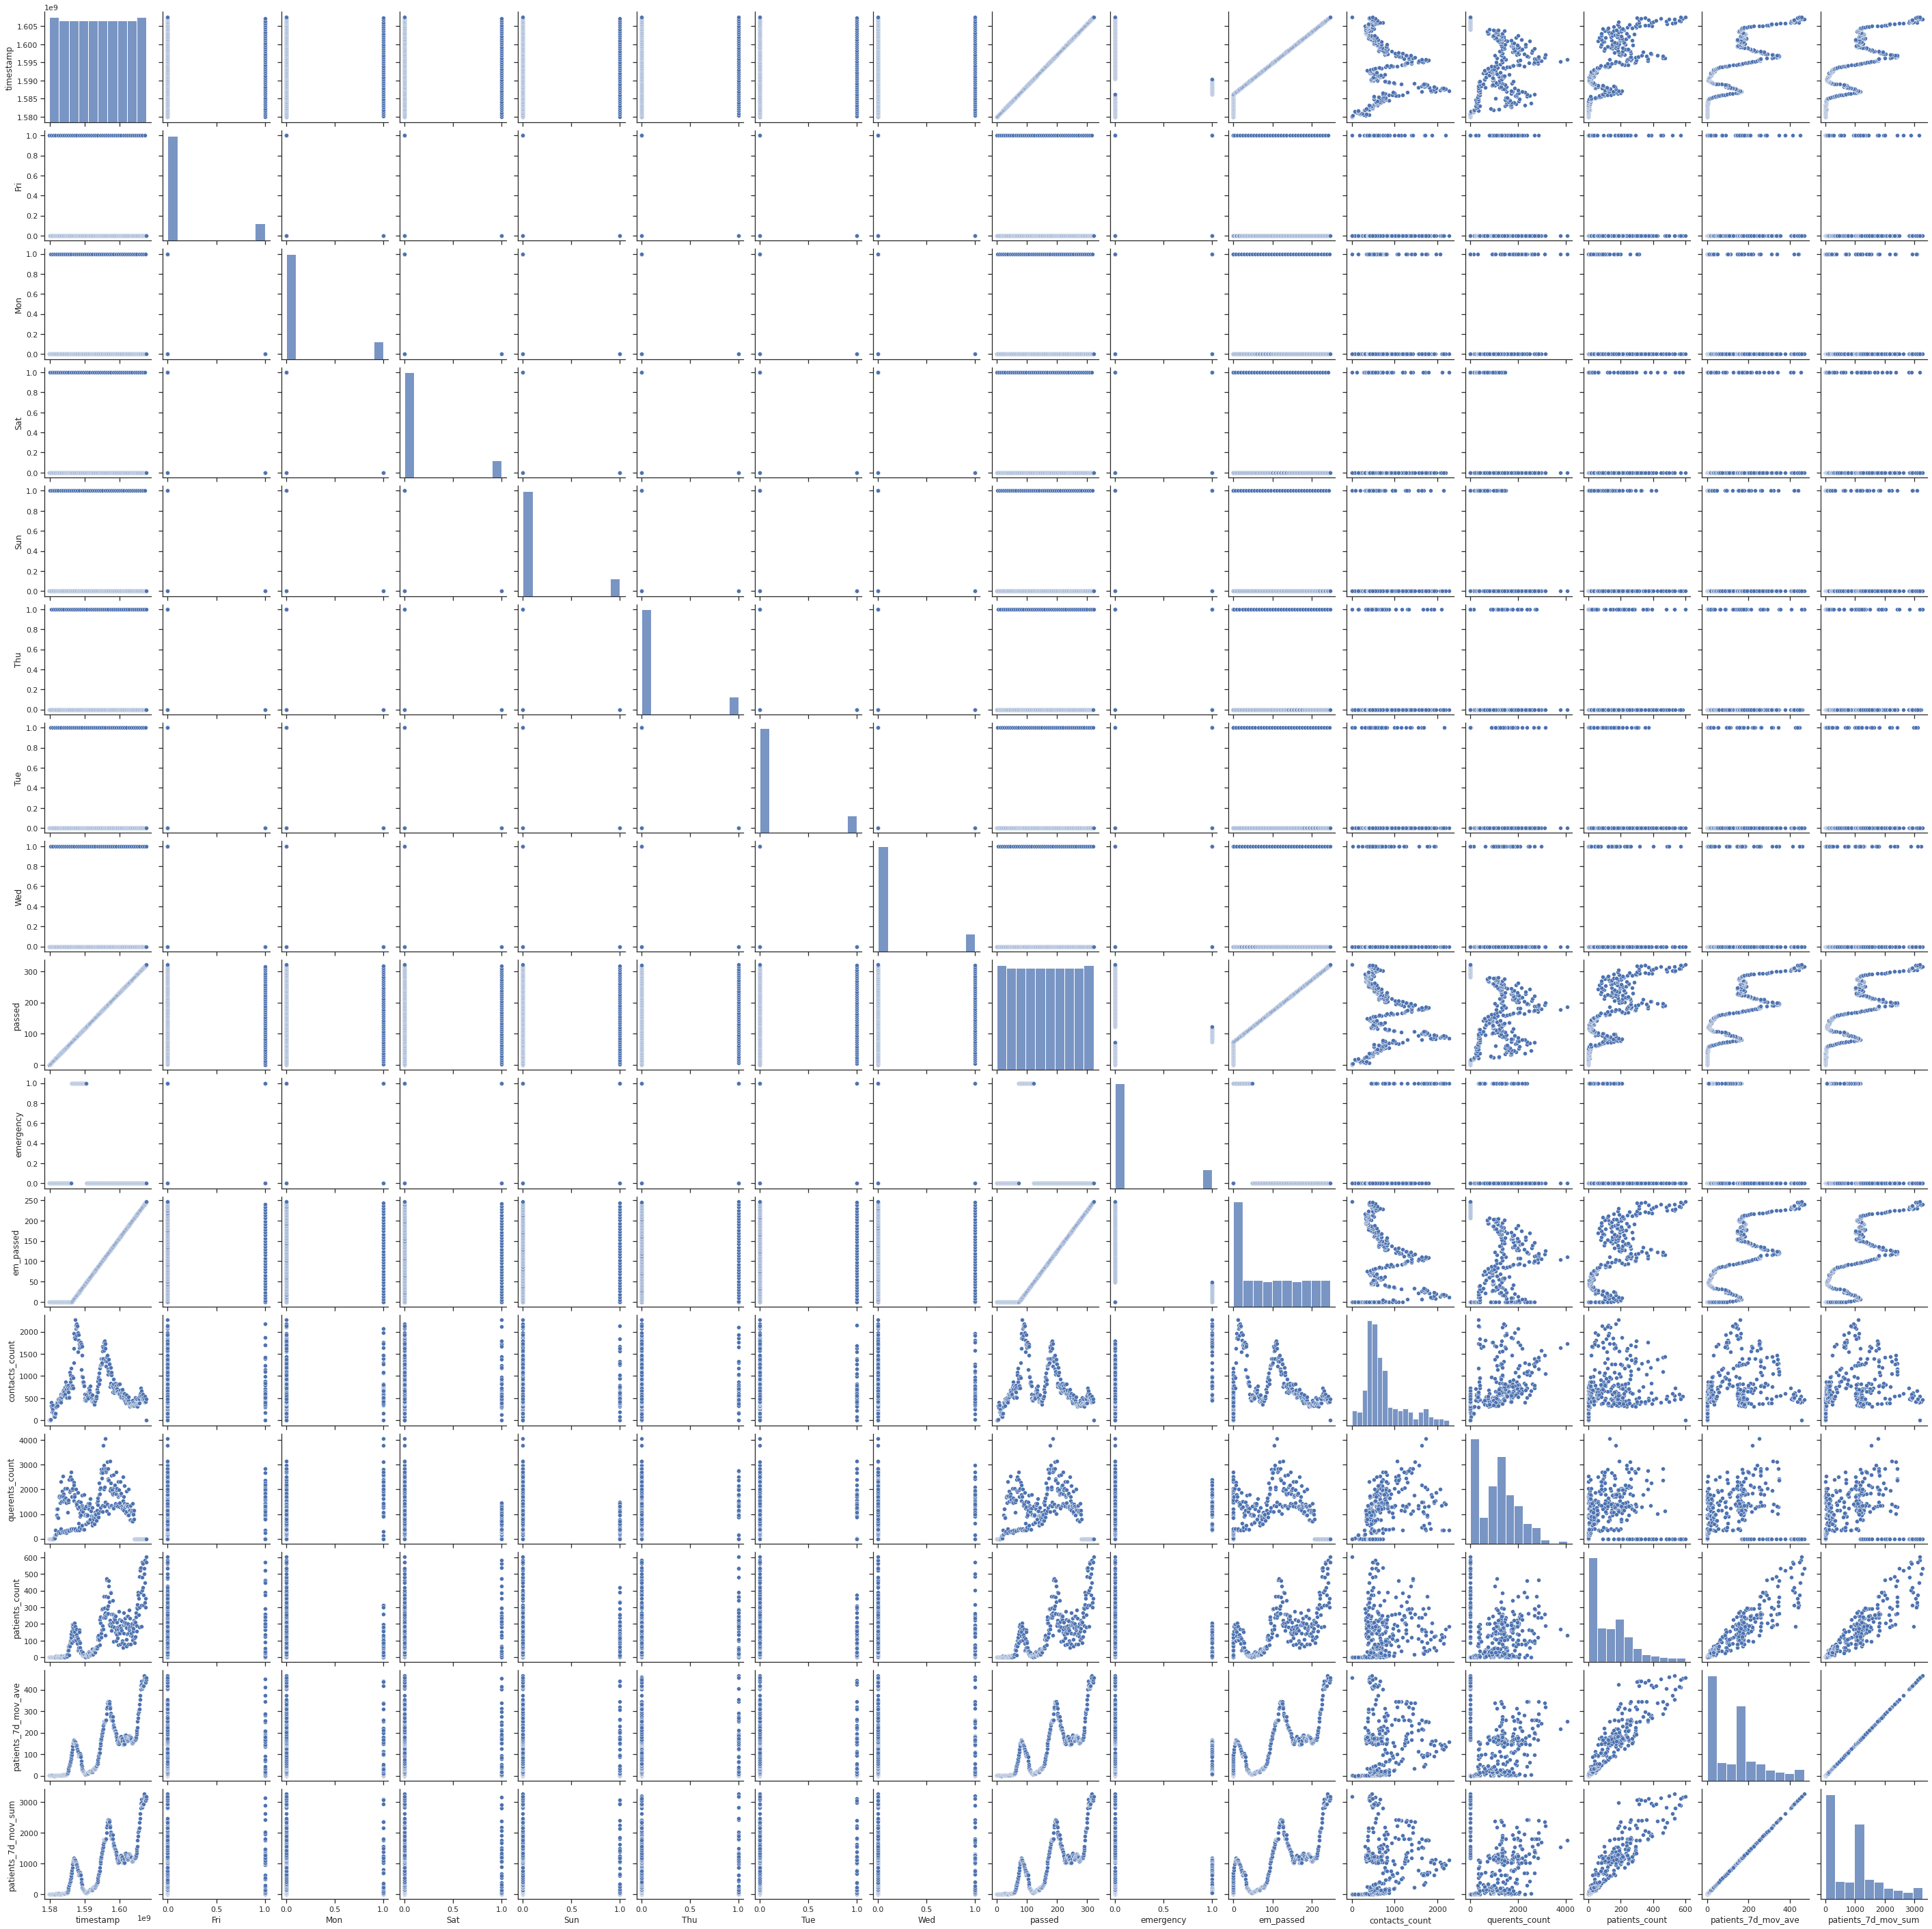

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
